<a href="https://colab.research.google.com/github/proofgeist/js-dashboard-dcjs-template/blob/main/Proof%2BGeist_Services_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interdep Services Account/Project Stats

## Initializing stuff

In [ ]:
%%shell

# Set the desired data rate limit (in bytes per second)
DATA_RATE_LIMIT=10000000  # 10 MB/s

# Update the Jupyter Notebook configuration
mkdir -p ~/.jupyter
echo "c.NotebookApp.iopub_data_rate_limit = $DATA_RATE_LIMIT" >> ~/.jupyter/jupyter_notebook_config.py

# Restart the Jupyter Notebook server to apply the changes
pkill -f jupyter-notebook

In [ ]:
! pip install fmrest
from fmrest import dataAPI
from datetime import datetime, timedelta
from google.colab import userdata
import pandas as pd
userdata.get('hkpwd')
username = 'fmrest'
password = userdata.get('hkpwd')
host = 'shallan-new.gicloud.net'
db_name = 'ZeitgeistV2'

Define the query range for our dataset. NB: We need to convert the python date object into a str for FileMaker query operations via the DataAPI. For the purposes of this report, I am hitting ZeitgeistV2 and it's `TimeEntries` layout.

## Pull data from Zeitgeist via DataAPI

In [ ]:
today_date = datetime.today().date()
date_range = today_date - timedelta(days=365)
# print (date_range)
fm_date = date_range.strftime("%m/%d/%Y")
fm = dataAPI.DataAPIv1(host)


try:
  fm.authenticate(db_name, username, password)
  if fm.errorCode !=0:
    print(fm.errorMessage)
except Exception as e:
  print(f"an authentication error occured: {e}")

def fetchdata():
  layoutName = 'TimeEntries_web'
  data = {
      "query": [
          {
          "spent_date": ">="+fm_date,
          "Billable": "1"
          },
          {
          "spent_date": "?*",
          "omit" : "true"
          },
          {
          "TimeItem_customer::isInternal": "1",
          "omit" : "true"
          },
          ],
      "sort": [
          {"fieldName": "spent_date", "sortOrder": "ascend"}
      ],
      "limit" : 100000,
      "offset": 1

  }
  result =  fm.find_records(layoutName, data)
  return result


In [ ]:
output = fetchdata()

In [ ]:
print(output)

{'response': {'dataInfo': {'database': 'ZeitgeistV2', 'layout': 'TimeEntries_web', 'table': 'hvTimeEntries', 'totalRecordCount': 67689, 'foundCount': 9443, 'returnedCount': 9443}, 'data': [{'fieldData': {'billable': 1, 'client.id': 5131301, 'client.name': 'Archbishop Mitty', 'spent_date': '05/02/2023', 'TimeItem_Customer::isInternal': '', 'TimeItem_Customer::PrincipalNameDisplay': 'Peter Vinogradov', 'hours': 1.6, 'billable_rate': 225, 'TimeItems::TotalLineBillable': 393.75}, 'portalData': {}, 'recordId': '55063', 'modId': '17'}, {'fieldData': {'billable': 1, 'client.id': 5131301, 'client.name': 'Archbishop Mitty', 'spent_date': '05/02/2023', 'TimeItem_Customer::isInternal': '', 'TimeItem_Customer::PrincipalNameDisplay': 'Peter Vinogradov', 'hours': 1.94, 'billable_rate': 225, 'TimeItems::TotalLineBillable': 450}, 'portalData': {}, 'recordId': '55069', 'modId': '11'}, {'fieldData': {'billable': 1, 'client.id': 994803, 'client.name': "St. Andrew's School", 'spent_date': '05/02/2023', 'T

In [ ]:
data_entries = output['response']['data']
field_data_list = [entry['fieldData'] for entry in data_entries]
output['response']['data']
df = pd.DataFrame(field_data_list)

# spent_date conversion

df['spent_date'] = pd.to_datetime(df['spent_date'], format='%m/%d/%Y')

df['spent_month'] = df['spent_date'].dt.month
df['spent_year'] = df['spent_date'].dt.year

In [40]:
# @title dataframe view
pd.set_option('display.width', 1000)
print(df)

      billable  client.id                        client.name spent_date TimeItem_Customer::isInternal TimeItem_Customer::PrincipalNameDisplay  hours billable_rate  TimeItems::TotalLineBillable  spent_month  spent_year
0            1    5131301                   Archbishop Mitty 2023-05-02                                                      Peter Vinogradov   1.60           225                        393.75            5        2023
1            1    5131301                   Archbishop Mitty 2023-05-02                                                      Peter Vinogradov   1.94           225                        450.00            5        2023
2            1     994803                St. Andrew's School 2023-05-02                                                              Mike Lee   0.43           250                        125.00            5        2023
3            1   13381265                           StateDPT 2023-05-02                                                         

In [ ]:
def format_billable_amount(amount):
    return '${:,.2f}'.format(amount)

In [53]:
# rename columns
df.columns = ['is_billable', 'client_id', 'client_name', 'spent_date', 'is_internal', 'principal', 'hours', 'billable_rate', 'billable_amount', 'spent_mo', 'spent_year']
df['billable_amount'] = pd.to_numeric(df['billable_amount'])

# summarize by client, principal
grouped_data = df.groupby(['client_name', 'principal']).agg({'hours': 'sum', 'billable_amount': 'sum', 'spent_date': ['min', 'max']})
grouped_data['hours','sum'] = grouped_data['hours', 'sum'].round(2)
grouped_data['billable_amount','sum'] = grouped_data['billable_amount', 'sum']
grouped_data.columns = ['total_hours', 'total_billable', 'from', 'to']
print(grouped_data)

                                                            total_hours  total_billable       from         to
client_name                               principal                                                          
Archbishop Mitty                          Peter Vinogradov      1742.02       416193.75 2023-05-02 2024-04-30
Armbrae Academy                           Mike Lee                70.19        23475.00 2023-05-04 2024-04-03
Associated Construction Publications, LLC Peter Vinogradov        75.89        15216.25 2023-05-02 2024-04-19
Baker Home Enterprises LLC                Martha Zink             77.66        20937.50 2023-05-02 2024-03-29
Bellport Property Management              Martha Zink             53.36        14250.00 2024-02-13 2024-04-30
...                                                                 ...             ...        ...        ...
Van Bind                                  Martha Zink             23.83         6500.00 2024-03-06 2024-04-10
Village An

Active projects by principal

In [58]:
df_principal_summary = df.groupby(['principal']).agg({'hours': 'sum', 'billable_amount': 'sum', 'spent_date': ['min', 'max']})

# sort by billable_amount
df_principal_summary = df_principal_summary.sort_values(by=('billable_amount', 'sum'), ascending=False)
df_principal_summary['billable_amount', 'sum'] = df_principal_summary['billable_amount', 'sum'].apply(format_billable_amount)
df_principal_summary.columns = ['total_hours', 'total_billable', 'from', 'to']

print(df_principal_summary)

                  total_hours total_billable       from         to
principal                                                         
Mike Lee              3647.81    $928,098.25 2023-05-02 2024-04-30
Martha Zink           2731.35    $640,402.50 2023-05-02 2024-04-30
Peter Vinogradov      1920.27    $453,900.00 2023-05-02 2024-04-30
Ernest Koe             966.93    $239,477.50 2023-05-02 2024-04-30
Dirk Reynolds          506.44     $88,526.25 2023-05-23 2024-04-30
Krissy Ferris          191.41     $16,702.50 2023-05-08 2023-12-15
Unassigned               9.18      $2,302.50 2023-05-08 2024-04-24


## Pretty Interactive Report

In [55]:
from IPython.display import display
display(grouped_data)

,,total_hours,total_billable,from,to
client_name,principal,,,,
Archbishop Mitty,Peter Vinogradov,1742.02,416193.75,2023-05-02,2024-04-30
Armbrae Academy,Mike Lee,70.19,23475.00,2023-05-04,2024-04-03
"Associated Construction Publications, LLC",Peter Vinogradov,75.89,15216.25,2023-05-02,2024-04-19
Baker Home Enterprises LLC,Martha Zink,77.66,20937.50,2023-05-02,2024-03-29
Bellport Property Management,Martha Zink,53.36,14250.00,2024-02-13,2024-04-30
...,...,...,...,...,...
Van Bind,Martha Zink,23.83,6500.00,2024-03-06,2024-04-10
Village Antiques,Dirk Reynolds,9.11,2437.50,2023-12-12,2024-03-27
Vintage 329,Dirk Reynolds,1.50,375.00,2023-05-23,2023-05-23


(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 [Text(-10.0, 0, '(Trace Analytics, LLC, Martha Zink)'),
  Text(0.0, 0, '(Archbishop Mitty, Peter Vinogradov)'),
  Text(10.0, 0, '(Bridgton Academy, Mike Lee)'),
  Text(20.0, 0, '(Drug Store Property Advisors, Ernest Koe)'),
  Text(30.0, 0, '(Helton Law Group, Ernest Koe)'),
  Text(40.0, 0, '(MICDS, Peter Vinogradov)'),
  Text(50.0, 0, '(Peak 7 Adventures, Mike Lee)'),
  Text(60.0, 0, '(StateDPT, Mike Lee)'),
  Text(70.0, 0, '(Trace Analytics, LLC, Martha Zink)'),
  Text(80.0, 0, ''),
  Text(90.0, 0, '')])

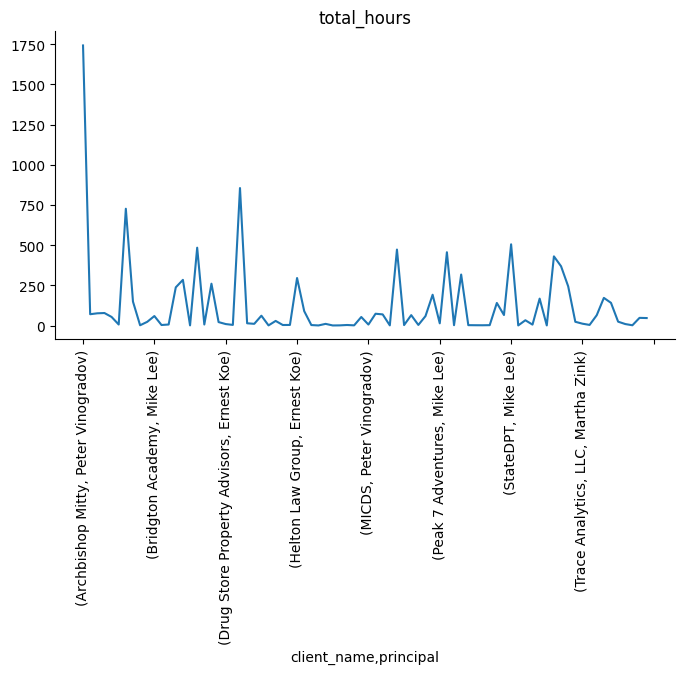

In [56]:
# @title total_hours

from matplotlib import pyplot as plt
grouped_data['total_hours'].plot(kind='line', figsize=(8, 4), title='total_hours')
plt.gca().spines[['top', 'right']].set_visible(False)
plt.xticks(rotation='vertical')


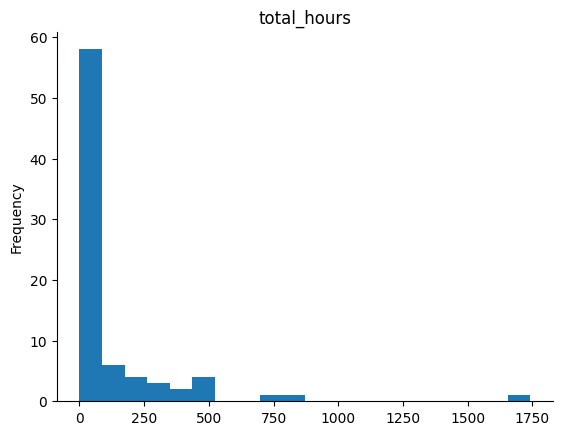

In [57]:
# @title total_hours

from matplotlib import pyplot as plt
grouped_data['total_hours'].plot(kind='hist', bins=20, title='total_hours')
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
fm.logout()
